In [1]:
import numpy as np 
import pandas as pd
import os
import random
import seaborn as sns
from math import *
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import IPython
import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalizationm LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


In [2]:
''' reading dataset '''
df = pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")

In [3]:
''' changing data type and doing scaling '''
df['pixels'] = df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))/255

In [4]:
''' dropping img_name from df '''
df = df.drop('img_name',axis=1)

In [5]:
''' plotting images '''
def samp(xs):
    n = len(xs)
    n_rows = ceil(n/5)
    n_cols = n if n < 5  else 5

    ''' plotting images '''
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    
    for x, i in zip(axes,[i for i in range(n)]):
        ''' reshaping image '''
        img = np.asarray(df.loc[x,"pixels"]).reshape(48, 48)
        title = "age : " + str(df.loc[x,'age']) +" ethnie : "+ str(df.loc[x,'ethnicity'])+ " genre : "+ str(df.loc[x,'gender'])
        ax = axes[i // n_cols, i % n_cols]
        ''' plotting '''
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(title, fontsize=24)

    plt.tight_layout()
    plt.show()

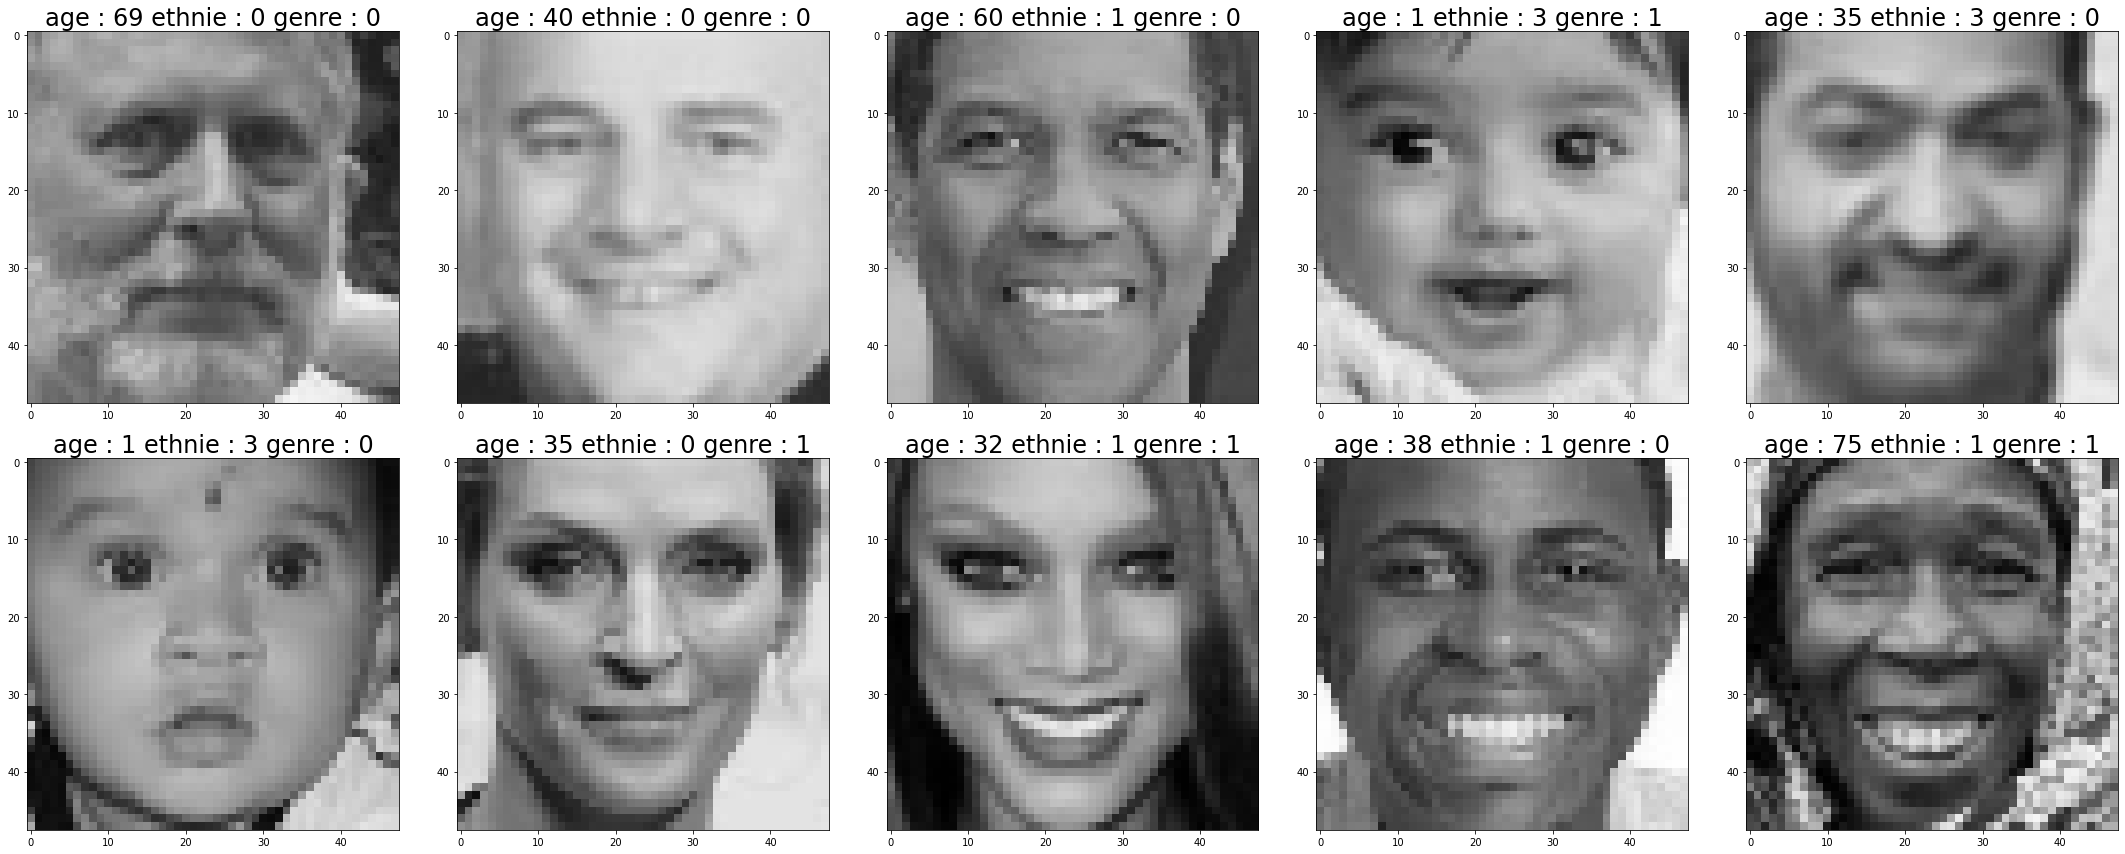

In [6]:
''' calling function '''
samp([random.randint(0,len(df)) for i in range(10)])

In [7]:
''' EDA '''

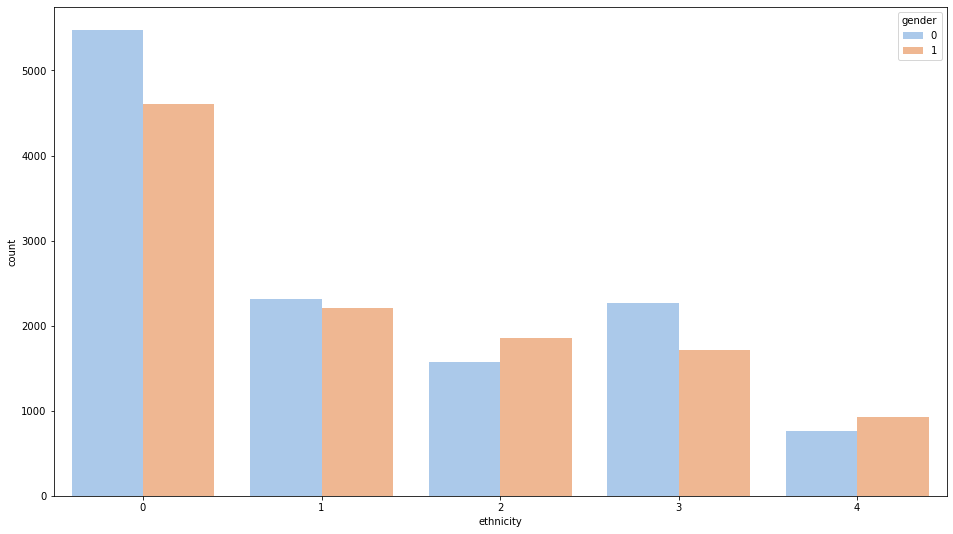

In [8]:
''' count plot '''
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='ethnicity',hue="gender", data = df) 

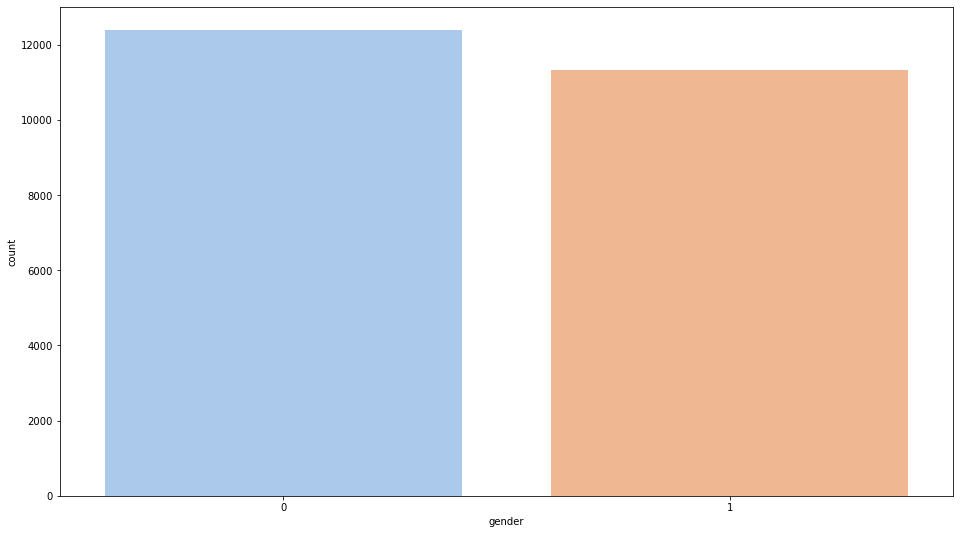

In [9]:
''' count plot '''
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='gender', data = df) 

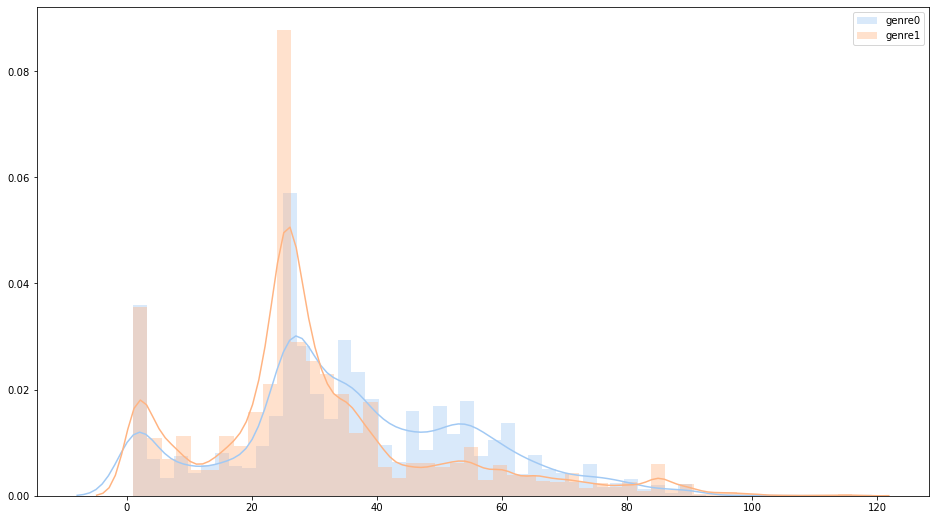

In [10]:
''' distribution plot '''
plt.figure(figsize=(16,9))
sns.distplot(df.loc[df.gender==0,["age"]],bins=50,label="genre0")
sns.distplot(df.loc[df.gender==1,["age"]],bins=50,label="genre1")
plt.legend()

In [11]:
X = df['pixels']

In [12]:
X_t = []
for i in range(X.shape[0]):
    ''' reshaping data '''
    X_t.append(X[i].reshape(48,48,1))
X = np.array(X_t)

In [13]:
''' train test split '''
X_train, X_test, y_train_gender, y_test_gender, y_train_ethnicity, y_test_ethnicity, y_train_age, y_test_age = train_test_split(
    X, pd.get_dummies(df['gender']).values, pd.get_dummies(df['ethnicity']).values, df['age'].values,test_size=0.1, 
    random_state=1234)

In [14]:
''' validation test split '''
X_val, X_test, y_val_gender, y_test_gender, y_val_ethnicity, y_test_ethnicity, y_val_age, y_test_age = train_test_split(
    X_test, y_test_gender, y_test_ethnicity, y_test_age,test_size=0.5, random_state=1234)

In [15]:
''' installing keras tunner '''
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /opt/conda/lib/python3.7/site-packages (1.0.1)


In [17]:
''' Model Building '''
def model_building(hp):
    inp = tf.keras.Input(shape=(48, 48, 1))
    x = inp
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            
            ''' Convolutonal Layer '''
            x = tf.keras.layers.Convolution2D(filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.LeakyReLU(hp.Float('alpha', 0, 0.3, step=0.01, default=0.01))(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = layers.Flatten()(x)
    
    ''' Hidden layer '''
    x = layers.Dense(units=hp.Int('units', min_value=32, max_value=1024, step=32), activation='relu')(x)
    x = tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    x = layers.Dense(units=hp.Int('units', min_value=32, max_value=1024, step=32), activation='relu')(x)

    ''' '''
    output_gender = layers.Dense(2, activation='sigmoid', name='gender_out')(x) 
    output_ethnicity = layers.Dense(5, activation='softmax', name='ethnicity_out')(x) 
    output_age = layers.Dense(1, name='age_out')(x) 

    ''' final model '''
    model = tf.keras.Model(inputs=inputs, outputs=[out_gender, out_ethnicity, out_age])

    ''' compile the model '''
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss={'gender_out':'BinaryCrossentropy', 'ethnicity_out':'categorical_crossentropy', 'age_out':'mse'},
        metrics={'gender_out':'accuracy', 'ethnicity_out':'accuracy', 'age_out':'mae'})
    return model

## Instantiate the tuner and perform hypertuning

In [18]:
k_tuner = kt.Hyperband(model_building, objective='val_loss', max_epochs=40,directory = '../kaggle/working/', 
                     project_name = 'Keras_tuning')

###callback to clear the training outputs at the end of every training step

In [19]:
class clear_training_output(tf.keras.callbacks.Callback):
      def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [20]:
k_tuner.search(X_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
             validation_data=(X_val, [y_val_gender, y_val_ethnicity, y_val_age]),
             callbacks= [ClearTrainingOutput()])

In [21]:
''' best parameters '''
best_params = tuner.get_best_hyperparameters(1)[0]

# Get the optimal hyperparameters
b_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {b_hps.get('units')} and the optimal learning rate for the optimizer
is {b_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 896 and the optimal learning rate for the optimizer
is 0.0002255275563378355.



In [22]:
''' Model '''
model = k_tuner.hypermodel.build(b_hps)

''' lets how model looks like '''
best_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 160)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 160)  640         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 48, 48, 160)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [23]:
batch_size = 32
epochs = 47
hist_list = []

In [24]:
''' training '''
history = best_model.fit(X_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
                         batch_size=batch_size, epochs = epochs, steps_per_epoch=(x_train.shape[0] // batch_size),
                         validation_data = (X_val, [y_val_gender, y_val_ethnicity, y_val_age]))

''' appending results to hist_list '''
hist_list.append(history)

Epoch 1/47
666/666 [==============================] - 22s 33ms/step - loss: 168.7946 - gender_out_loss: 0.7042 - ethnicity_out_loss: 1.5130 - age_out_loss: 166.5773 - gender_out_accuracy: 0.5889 - ethnicity_out_accuracy: 0.3948 - age_out_mae: 9.3940 - val_loss: 107.3013 - val_gender_out_loss: 0.5927 - val_ethnicity_out_loss: 1.3602 - val_age_out_loss: 105.3483 - val_gender_out_accuracy: 0.7038 - val_ethnicity_out_accuracy: 0.4591 - val_age_out_mae: 7.4156
Epoch 2/47
666/666 [==============================] - 22s 32ms/step - loss: 101.5424 - gender_out_loss: 0.6500 - ethnicity_out_loss: 1.3905 - age_out_loss: 99.5019 - gender_out_accuracy: 0.6417 - ethnicity_out_accuracy: 0.4360 - age_out_mae: 7.2168 - val_loss: 131.3813 - val_gender_out_loss: 0.5769 - val_ethnicity_out_loss: 1.3808 - val_age_out_loss: 129.4236 - val_gender_out_accuracy: 0.7139 - val_ethnicity_out_accuracy: 0.4034 - val_age_out_mae: 8.0541
Epoch 3/47
666/666 [==============================] - 22s 33ms/step - loss: 84.42

In [25]:
''' Training Loss and Validation Loss graph '''
def plot_loss_graph(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['gender_out_loss'], label='train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_loss'], label='train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['age_out_loss'], label='train_age_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_loss'], label='val_train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_loss'], label='val_train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_loss'], label='val_train_age_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
''' Training Accuracy and Validation Accuracy graph '''
def plot_acc_graph(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['gender_out_accuracy'], label='train_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_accuracy'], label='train_ethnicity_accuracy')
        
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_accuracy'], label='val_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_accuracy'], label='val_ethnicity_accuracy')


    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

''' plotting mse '''
def plot_MSE_graph(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['age_out_mae'], label='train_age_mae')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_mae'], label='val_age_mae')

    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.show()

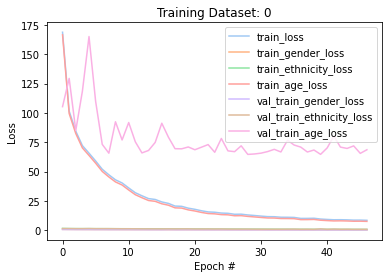

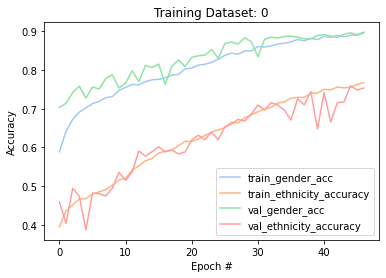

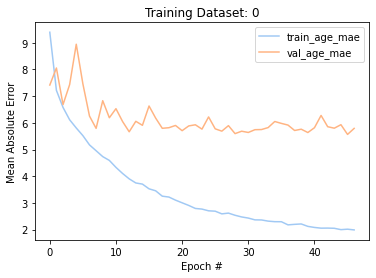

In [26]:
    plot_loss_graph(hist_list[0], epochs, f'Training Dataset: {0}')
    plot_acc_graph(hist_list[0], epochs, f'Training Dataset: {0}')
    plot_MSE_graph(hist_list[0], epochs, f'Training Dataset: {0}')

In [27]:
''' prediction '''
ypred = model.predict(X_test)

test_l, test_gender_l, test_ethnicity_l, test_age_l, test_gender_acc,test_ethnicity_acc,test_age_mae = modle.evaluate(X_test, [y_test_gender, y_test_ethnicity, y_test_age], verbose=0)
print(f'\nTest gender accuracy: {test_gender_acc}')
print(f'\nTest ethnicity accuracy: {test_ethnicity_acc}')
print(f'\nTest age MAE: {test_age_mae}')


Test gender accuracy: 0.8802698254585266

Test ethnicity accuracy: 0.7411466836929321

Test age MAE: 5.5310797691345215


In [28]:
''' Checking Performance of Model '''
ypred = np.argmax(pred[0],axis=1)
actual = np.argmax(y_test_gender,axis = 1)

print('Confusion Matrix')
print(confusion_matrix(actual, ypred))

print('Classification Report')
label_names = ['Woman', 'Man']
print(classification_report(actual, ypred, target_names=label_names))

Confusion Matrix
[[514  86]
 [ 56 530]]
Classification Report
              precision    recall  f1-score   support

       Woman       0.90      0.86      0.88       600
         Man       0.86      0.90      0.88       586

    accuracy                           0.88      1186
   macro avg       0.88      0.88      0.88      1186
weighted avg       0.88      0.88      0.88      1186



In [29]:
ypred_ethn = np.argmax(ypred[1],axis=1)
actual_ethn = np.argmax(y_test_ethnicity,axis = 1)

print('Confusion Matrix')
print(confusion_matrix(Y_true_ethnicity, Y_pred_Ethn))

print('Classification Report')
lbl_names = ['0', '1','2','3','4']
print(classification_report(actual_ethn, ypred_ethhn, target_names=lbl_names))

Confusion Matrix
[[460  26  11  13   3]
 [ 19 212   2   6   3]
 [ 37   5 108   2   0]
 [ 57  30   3  98   3]
 [ 60  13   5   9   1]]
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.90      0.80       513
           1       0.74      0.88      0.80       242
           2       0.84      0.71      0.77       152
           3       0.77      0.51      0.61       191
           4       0.10      0.01      0.02        88

    accuracy                           0.74      1186
   macro avg       0.63      0.60      0.60      1186
weighted avg       0.70      0.74      0.71      1186



In [30]:
''' disp function '''
def disp_err(errors_idx, img_err, pred_err, obs_err):
    """ This function shows 10 images with their predicted and real labels"""
    num = 0
    n_rows = 2
    n_cols = 5
    fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20, 8))
    for row in range(n_rows):
        for col in range(n_cols):
            e = errors_index[num]
            ax[row,col].imshow((img_err[e]).reshape((48,48)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_err[e], obs_err[e]))
            num += 1
    plt.show()

In [31]:
''' gender error '''

ypred_gender = np.argmax(pred[0],axis=1)
actual_gender = np.argmax(y_test_gender,axis = 1)

In [32]:
err_gender = (ypred_gender - actual_gender != 0)

In [33]:
yred_gender_class_err = ypred_gender[err_gender]
ypred_gender_errors = pred[0][errors_gender]
ytrue_err = actual_gender[errors_gender]
X_val_errors = X_test[err_gender]

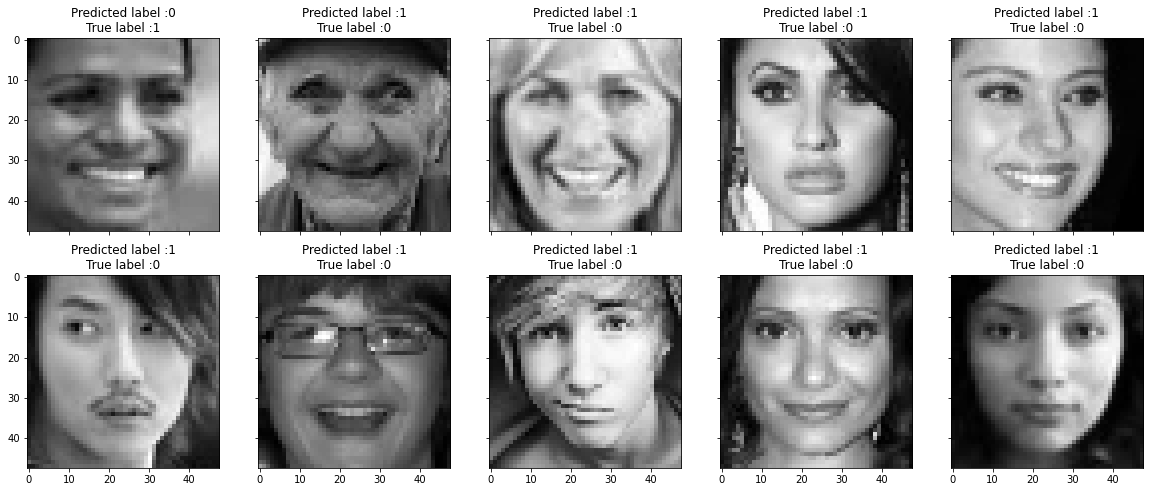

In [34]:
Y_pred_gender_errors_prob = np.max(Y_pred_gender_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_gender_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_gender_errors_prob - true_prob_errors
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, x_val_errors, Y_pred_gender_class_errors, Y_true_errors)

In [35]:
''' ethnicity error '''

Y_pred_ethnicity = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_test_ethnicity,axis = 1)

In [36]:
errors_ethnicity = (Y_pred_ethnicity - Y_true_ethnicity != 0)

In [37]:
Y_pred_ethnicity_class_errors = Y_pred_ethnicity[errors_ethnicity]
Y_pred_ethnicity_errors = pred[1][errors_ethnicity]
Y_true_ethnicity_errors = Y_true_ethnicity[errors_ethnicity]
x_test_ethnicity_errors = x_test[errors_ethnicity]

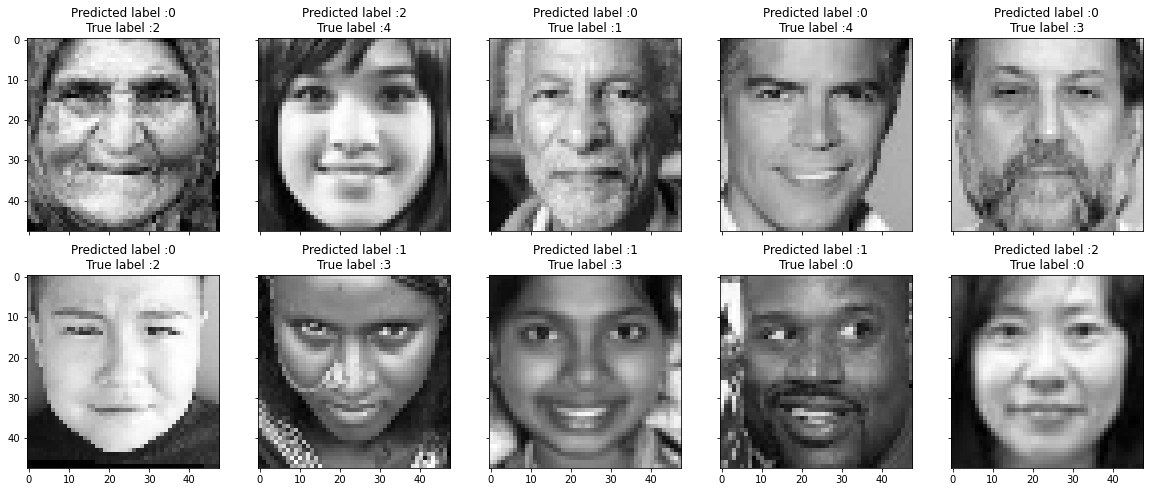

In [38]:
Y_pred_ethnicity_errors_prob = np.max(Y_pred_ethnicity_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_ethnicity_errors, Y_true_ethnicity_errors, axis=1))
delta_pred_true_ethnicity_errors = Y_pred_ethnicity_errors_prob - true_prob_errors
sorted_delta_ethnicity_errors = np.argsort(delta_pred_true_ethnicity_errors)
most_important_errors = sorted_delta_ethnicity_errors[-10:]

display_errors(most_important_errors, x_test_ethnicity_errors, Y_pred_ethnicity_class_errors, Y_true_ethnicity_errors)

In [39]:
''' Age Error'''

Y_pred_age = np.around(pred[2]).reshape(pred[2].size)
Y_true_age = y_test_age

In [40]:
MSE_age =np.sqrt((Y_pred_age-Y_true_age)**2)

In [41]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)


In [42]:
Max_MSE_age=largest_indices(MSE_age, 10)[0]

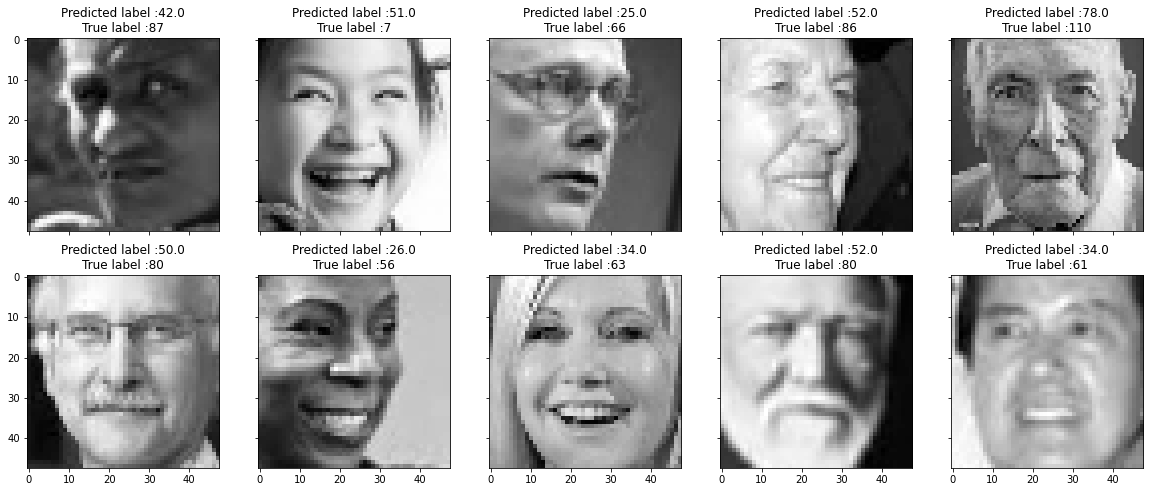

In [43]:
display_errors(Max_MSE_age, x_test, Y_pred_age, Y_true_age)